# 01. Machine Learning
 - Vamos estabelecer primariamente um modelo baseline para melhor interpretabilidade.
 - Nosso objetivo será controlar o ERRO TIPO 2(Falso Negativo) para não perder receita recorrente (LTV - Lifetime Value)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando os dados processados
X_train = pd.read_csv('../data/processed/X_train_processed.csv')
y_train = pd.read_csv('../data/processed/y_train_processed.csv')

X_test = pd.read_csv('../data/processed/X_test_processed.csv')
y_test = pd.read_csv('../data/processed/y_test_processed.csv')

# O y é carregado como DataFrame, mas modelos preferem vetor (Series 1D)
# O .ravel() resolve isso achatando o array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print(f"Dados carregados! Treino: {X_train.shape}, Teste: {X_test.shape}")

Dados carregados! Treino: (5634, 29), Teste: (1409, 29)


--- Baseline: Regressão Logística ---
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



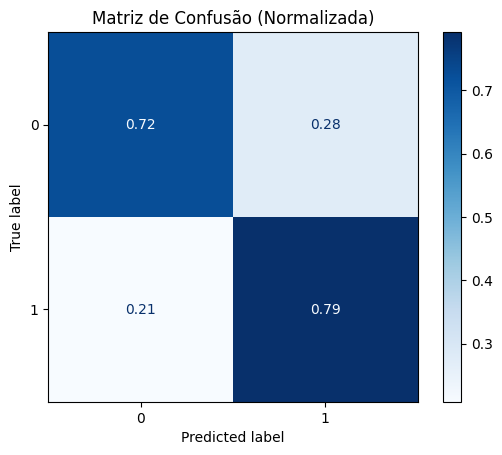

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Instanciar o modelo
# class_weight='balanced': Isso é CRUCIAL! 
# Como temos menos churn (26%), mandamos o modelo dar "mais atenção" pra quem sai.
# Isso ajuda a aumentar o Recall naturalmente.
model_logreg = LogisticRegression(class_weight='balanced', random_state=1997, max_iter=1000)

model_logreg.fit(X_train, y_train)

y_pred_logreg = model_logreg.predict(X_test)

print("--- Baseline: Regressão Logística ---")
print(classification_report(y_test, y_pred_logreg))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, cmap='Blues', normalize='true')
plt.title('Matriz de Confusão (Normalizada)')
plt.show()